In [1]:
import sys
import sys
sys.path.append('../build/')

from PyGMO import algorithm, island, archipelago
import versor as vsr
%pylab inline
np.set_printoptions(precision=6, suppress=True)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)
versor/cga.py:4: RuntimeWarning: to-Python converter for vsr::Multivector<vsr::algebra<vsr::metric<4, 1, true>, double>, vsr::Basis<(short)1, (short)2, (short)4, (short)8, (short)16> > already registered; second conversion method ignored.
  from libversor import (Biv, Bst, Cir, Con, Dil, Dll, Dlp, Dls, Drb, Drt, Drv,


In [2]:
fig_width_pt =  332.89726  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5.0)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]
params = {
    'axes.labelsize': 9,
    'font.size': 9,
    "font.family": "serif",
    "font.serif": [],
    'legend.fontsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'text.latex.preamble':[r'\usepackage{amsmath}', r'\usepackage{bm}'],
    'figure.figsize': fig_size,
    'axes.linewidth': 0.5
}
matplotlib.rcParams.update(params)

# PK8103 Swarm Intelligence

This notebook implements the swarm intelligence algorithms **Ant Colony Optimization (ACO)**, **Artificial Bee Colony Optimization (ABC)** and **Particle Swarm Optimization (PSO)** for estimation of **rigid body motion motors** from point clouds using **Conformal Geometric Algebra (CGA)**.

## Conformal Geometric Algebra

### Polar Decomposition

$$M = \frac{X}{|X|}\left(1 - \frac{\langle X \widetilde{X} \rangle_4}{2 \langle X \widetilde{X} \rangle} \right),\ X \in \mathbb{M}$$

In [3]:
def polar_decomposition(x):
    xx = x * x.rev()
    sinv = (vsr.Sca(1.0) + (vsr.Drt(- xx[7] / (2 * xx[0]))))
    return x * sinv

### Cost Function

$$ C = \sum_i^n \| \mathcal{K}^{-1}(b_i) - \mathcal{K}^{-1}(M a_i \widetilde{M})    \|^2 $$

In [4]:
def cost_function(m):
    global points_a, points_b, points_b_noisy
    mot = vsr.Mot(*m.ravel())
    mot = polar_decomposition(mot)
    b_ = [point.spin(mot) for point in points_a]
    b = points_b_noisy
#     b = points_b
    return np.sum([np.linalg.norm(pa.to_array()[:3] - 
                                  pb.to_array()[:3]) for pa, pb in zip(b, b_)])

### Dataset generation

In [98]:
n = 10
n_points = n
sigma = 0.09
motor = vsr.Trs.from_vector(vsr.Vec(1,1,1)) * vsr.Rot.from_bivector(vsr.Biv(0,1,0) * np.pi/6.0)
points_as = []
points_bs = []
points_bns = []
for i in range(3):
    points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n)]
    points_b = [point.spin(motor) for point in points_a]
    points_b_noisy = [vsr.Vec(*(point.to_array()[:3] + sigma * np.random.randn(3))).null() for point in points_b]
    points_as.append(points_a)
    points_bs.append(points_b)
    points_bns.append(points_b_noisy)

In [50]:
motor.to_array()

array([ 0.965926,  0.      , -0.258819,  0.      , -0.612372, -0.482963,
       -0.353553, -0.12941 ])

### RMS Distance

In [6]:
def rms_distance(final_motor):
    global points_a, points_b
    points_b_estimated = [point.spin(final_motor) for point in points_a]
    rms_distance = np.sum([ np.linalg.norm(a.to_array()[:3] - b.to_array()[:3])
                            for a, b in zip(points_b, points_b_estimated)]) / np.sqrt(n)
    return rms_distance

### PyGMO wrapper

In [7]:
from PyGMO.problem import base
class MotorEstimationProblem(base):
    def __init__(self, dim=8):
        super(MotorEstimationProblem,self).__init__(dim)
        self.set_bounds(-1, 1)
    
    def _objfun_impl(self, x):
        return (cost_function(x), )
    
    def human_readable_extra(self):
        return "\n\t Problem dimension: " + str(self.__dim)

## Artificial Bee Colony Optimization *(ABC)*

In [8]:
# prob = MotorEstimationProblem(dim=8)
# algo = algorithm.bee_colony(gen=1000)
# isl = island(algo, prob, 20)
# isl.evolve(1)
# isl.join()
# print(isl.population.champion.f[0])
# x = isl.population.champion.x
# m_bee = polar_decomposition(vsr.Mot(*x))
# print(m_bee)

In [19]:
class ArtificialBeeColonyAlgorithm(object):
    def __init__(self, 
                 objective_function, 
                 dimension, 
                 upper_bounds,
                 lower_bounds,
                 population_size, 
                 max_trial_limit, 
                 max_num_iterations,
                 debug=False):
        self._objective_function = objective_function
        self._dimension = dimension
        self._lower_bounds = lower_bounds
        self._upper_bounds = upper_bounds
        self._population_size = population_size
        self._food_size = self._population_size / 2
        self._max_trial_limit = max_trial_limit
        self._max_num_iterations = max_num_iterations
        
        self._foods = self._create_food(self._food_size)
        self._objective_values = self._calculate_objective_values(self._foods)
        self._fitness_values = self._calculate_fitness_values(self._objective_values)
        
        self._trials = np.zeros(self._food_size)
        
        self._best_index = np.argmin(self._objective_values)
        self._global_min_objective_value = self._objective_values[self._best_index]
        self._global_min_objective_values = [self._global_min_objective_value]
        self._global_best_food = self._foods[self._best_index,:]
        
        self._debug = debug
    
    def _create_food(self, size):
        food = np.random.random((size, dim)) *\
                np.tile(upper_bounds - lower_bounds, (size,1)) +\
                np.tile(lower_bounds, (size,1))
        return food
    
    def _calculate_objective_values(self, foods):
        return np.array([self._objective_function(solution) for solution in foods])
    
    def _calculate_fitness_values(self, objective_values):
        return np.array([1. / (objective_value + 1.) 
                         if objective_value >= 0. 
                         else 1. + np.abs(objective_value) 
                         for objective_value in objective_values])
    def _evaluate(self, i):
            j = np.random.random_integers(self._dimension) - 1
            k = np.random.random_integers(self._food_size) - 1
            while k == i:
                k = np.random.random_integers(self._food_size) - 1

            v_i = self._foods[i,:].copy()
            x_ij = self._foods[i,j]
            x_kj = self._foods[k,j]
            phi_ij = 2 * (np.random.rand() - 0.5)
            v_i[j] = x_ij + phi_ij * (x_ij - x_kj)

            # Check if parameter is outside bounds. If so set it to the 
            # limit.
            v_i = np.where(v_i < upper_bounds, v_i, upper_bounds).copy()
            v_i = np.where(v_i > lower_bounds, v_i, lower_bounds).copy()

            objective_value = self._calculate_objective_values([v_i])
            fitness_value = self._calculate_fitness_values(objective_value)

            if fitness_value > self._fitness_values[i]:
                self._foods[i,:] = v_i.copy()
                self._fitness_values[i] = fitness_value.copy()
                self._objective_values[i] = objective_value.copy()
                self._trials[i] = 0
            else:
                self._trials[i] = self._trials[i] + 1
        
    def _calculate_probabilities(self, fitness_values):
        '''p_i = fit_i / sum_i^n fit_i'''
        prob = fitness_values / np.sum(fitness_values)
#         prob = (0.9 * fitness_values / max(fitness_values)) + 0.1
        return prob
    
    def solve(self):
        for iteration in range(self._max_num_iterations):
            # Employed bee phase
            for i in range(self._food_size):
                self._evaluate(i)

            # Calculate probabilities. 
            # p_i = fit_i / sum_i^n fit_i
            probabilities = self._calculate_probabilities(self._fitness_values)

            # Onloooker bee phase
            i = 0
            t = 0
            while t < self._food_size:
                do_forage = np.random.rand() < probabilities[i]
                if do_forage:
                    t = t + 1
                    self._evaluate(i)
                i = i + 1
                if i == self._food_size:
                    i = 0

            # Update best solution
            best_index = np.argmin(self._objective_values)
            objective_value = self._objective_values[best_index]
            if objective_value < self._global_min_objective_value:
                self._best_index = best_index
                self._global_min_objective_value = objective_value
                self._global_best_food = self._foods[best_index,:]

            # Scout bee phase
            max_trial_idx = np.argmax(self._trials)
            max_trial = self._trials[max_trial_idx]
            if max_trial > self._max_trial_limit:
                self._trials[max_trial_idx] = 0
                v_i = self._create_food(1)
                objective_value = self._calculate_objective_values([v_i])
                fitness_value = self._calculate_fitness_values(objective_value)
                self._foods[max_trial_idx, :] = v_i.copy()
                self._fitness_values[max_trial_idx] = fitness_value.copy()
                self._objective_values[max_trial_idx] = objective_value

            self._global_min_objective_values.append(self._global_min_objective_value)
            if self._debug:
                if not iteration % 50:
                    print('Iteration: {}, f(x_i)_min: {}, i: {}'.format(iteration, 
                                                                        self._global_min_objective_value, 
                                                                        self._best_index))
        return self._global_best_food
    
    def plot(self, save_dir=None):
        fig, ax = plt.subplots(1)
        plt.set_cmap('gray')
        plt.xlabel(r'Iteration $k$')
        plt.ylabel(r'$f=C(x_k)$')
        ax.plot(self._global_min_objective_values)
#         plt.xscale('log')
        if save_dir is not None:
            fig.savefig(save_dir)


In [115]:
population_size = 20
max_trial_limit = 100
max_num_iterations = 200
dim = 8
upper_bounds = np.ones((1,dim)) * 1
lower_bounds = np.ones((1,dim)) * -1
rms_abc = []
residualss_abc = []
for points_a, points_b, points_b_noisy in zip(points_as, points_bs, points_bns):
    abc = ArtificialBeeColonyAlgorithm(cost_function, dim, 
                                   upper_bounds, lower_bounds, 
                                   population_size, max_trial_limit, 
                                   max_num_iterations, debug=False)
    residualss_abc.append(abc._global_min_objective_values)
    m_bee = polar_decomposition(vsr.Mot(*abc.solve()))
    rms_abc.append(rms_distance(m_bee))

In [116]:
mean_abc = np.mean(rms_abc)
std_abc = np.std(rms_abc)
print(mean_abc)
print(std_abc)

0.286464125092
0.110862148702


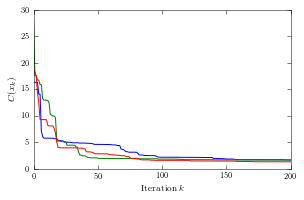

In [117]:
fig, ax = plt.subplots(1)
plt.set_cmap('gray')
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'$C(x_k)$')
for r in residualss_abc:
    ax.plot(r)
# plt.xscale('log')
fig.savefig('/Users/lars/Dropbox/sharelatex/PK8103/abc2.pdf')

In [ ]:
plt.bar(np.arange(10),abc._calculate_probabilities(abc._fitness_values))

In [ ]:
m_bee = polar_decomposition(vsr.Mot(*m_bee))
print(m_bee)


In [ ]:
rms_distance(vsr.Mot(*m_bee.to_array()))

## Particle Swarm Optimization *(PSO)*

In [103]:
from pso import *

lb = [-1] * 8
ub = [1] * 8

rms_pso = []
residualss = []
for points_a, points_b, points_b_noisy in zip(points_as, points_bs, points_bns):
    g, fg, residuals = pso(cost_function, lb, ub, 
           swarmsize=100, 
           maxiter=200, 
           minstep=1e-8, 
           minfunc=1e-8,
           omega=0.75,
           phip=0.75,
           phig=0.75)
    residualss.append(residuals)
    m_pso = polar_decomposition(vsr.Mot(*g))
    rms_pso.append(rms_distance(m_pso))

Stopping search: maximum iterations reached --> 200
Stopping search: maximum iterations reached --> 200
Stopping search: maximum iterations reached --> 200


In [104]:
rms_pso
mean_pso = np.mean(rms_pso)
std_pso = np.std(rms_pso)
print(mean_pso)
print(std_pso)

0.207573142099
0.0643192383569


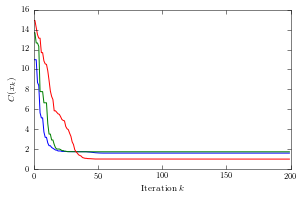

In [105]:
fig, ax = plt.subplots(1)
plt.set_cmap('gray')
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'$C(x_k)$')
for r in residualss:
    ax.plot(r)
# plt.xscale('log')
fig.savefig('/Users/lars/Dropbox/sharelatex/PK8103/pso2.pdf')

In [ ]:
prob = MotorEstimationProblem(dim=8)
algo = algorithm.pso(gen=1000)
isl = island(algo, prob, 20)
isl.evolve(1)
isl.join()
print(isl.population.champion.f[0])
x = isl.population.champion.x
m_pso = polar_decomposition(vsr.Mot(*x))
print(m_pso)

In [ ]:
rms_distance(m_pso)

### Genetic Algorithm

In [ ]:
prob = MotorEstimationProblem(dim=8)
algo = algorithm.sga(gen=4000)
isl = island(algo, prob, 10)
isl.evolve(1)
isl.join()
print(isl.population.champion.f[0])
x = isl.population.champion.x
m_sga = polar_decomposition(vsr.Mot(*x))
print(m_sga)

In [ ]:
rms_distance(m_sga)

## Ant Colony Optimization for Continuous Domains *(ACO$_\mathbb{R}$)*

In [99]:
from fatiando.inversion.solvers import acor
rms_acor = []
residualss_acor = []
for points_a, points_b, points_b_noisy in zip(points_as, points_bs, points_bns):
    solver = acor(cost_function, [-1,1], 8, diverse=0.001, evap=0.7, maxit=200)
    iterations = 0
    residuals = []
    for p in solver:
        iterations = iterations + 1
        residual = cost_function(p)
        residuals.append(residual)
    print(iterations)
    residualss_acor.append(residuals)
    m_ant = polar_decomposition(vsr.Mot(*p))
    rms_acor.append(rms_distance(m_pso))

201
201
201


In [100]:
mean_acor = np.mean(rms_acor)
std_acor = np.std(rms_acor)
print(mean_acor)
print(std_acor)

0.801690676837
0.0536327337438


In [85]:
print(m_ant)

-0.961292  0.0272316  0.264096  -0.0308311  0.622159  0.39122  0.383411  0.116573  


In [67]:
save_dir = '/Users/lars/Dropbox/sharelatex/PK8103/'

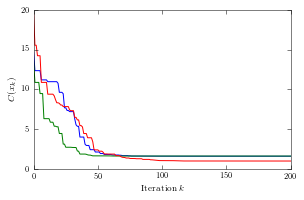

In [102]:

fig, ax = plt.subplots(1)
plt.set_cmap('gray')
plt.xlabel(r'Iteration $k$')
plt.ylabel(r'$C(x_k)$')
for r in residualss_acor:
    ax.plot(r)
# plt.xscale('log')
fig.savefig(save_dir + 'acor2.pdf')

In [ ]:
rms_distance(m_ant)

In [ ]:
plt.plot(residuals)
plt.xscale('log')

In [94]:
from motor_estimation import estimate_motor
summary, m_game = estimate_motor(5,1,10, points_a, points_b_noisy)
rms_distance(m_game)

game::Point vector. 3 residuals
game:: Original motor
0.965926  0  -0.258819  0  -0.612372  -0.482963  -0.353553  -0.12941  
game:: Estimated motor
0.950734  0.0344911  -0.303348  0.0538031  -0.564792  -0.529746  -0.311356  -0.212282  

Solver Summary (v 1.11.0-eigen-(3.2.5)-lapack-suitesparse-(4.4.4)-cxsparse-(3.1.4)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Residual blocks                            10                       10
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                       

0.91744737236313112

In [ ]:
points_a[0].to_array()

In [ ]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

c = random.rand(n_points)


x = [p.to_array()[0] for p in points_a]
y = [p.to_array()[1] for p in points_a]

ax.scatter(x, y, c='r',
           edgecolor=almost_black, linewidth=0.15, 
           label=r"$\{\bm{\mathrm{a}}_i\}$")
for i, txt in enumerate(range(n_points)):
    ax.annotate(txt, (x[i],y[i]))
    
x = [p.to_array()[0] for p in points_b]
y = [p.to_array()[1] for p in points_b]
ax.scatter(x,y,c='b',
           edgecolor=almost_black,linewidth=0.15, 
           label=r"$\{\bm{\mathrm{a}^\prime}_i\}$")
for i, txt in enumerate(range(n_points)):
    ax.annotate(txt, (x[i],y[i]))
    
    
x = [p.to_array()[0] for p in points_b_noisy]
y = [p.to_array()[1] for p in points_b_noisy]


ax.scatter(x,y,c='g',
           edgecolor=almost_black,linewidth=0.15, 
           label=r"$\{\bm{\mathrm{b}}_i\}$")
for i, txt in enumerate(range(n_points)):
    ax.annotate(txt, (x[i],y[i]))
    
ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.
light_grey = np.array([float(248)/float(255)]*3)
legend = ax.legend(frameon=True, scatterpoints=1)
rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

# Change the legend label colors to almost black, too
texts = legend.texts
for t in texts:
    t.set_color(almost_black)

plt.xlabel(r'$\bm{\mathrm{e}}_1$-axis $[\mathrm{m}]$')
plt.ylabel(r'$\bm{\mathrm{e}}_2$-axis $[\mathrm{m}]$')

plt.show()
fig.savefig(save_dir + '/motor_estimation_xy_proj.pdf')